# Classification of Reponse to Neoadjuvant Therapy: Data Analysis and Prediction

In [226]:
#pip install -q -U keras-tuner

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import collections
from collections import Counter
import statistics
import time 

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from matplotlib.colors import ListedColormap


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, Dropout, MaxPooling2D
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
import keras_tuner as kt
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

import sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import shap
from xgboost import XGBClassifier

pd.get_option("display.max_columns", None)

20

# load the data

In [3]:
dataframe = pd.read_csv(r"C:\Users\Catherine\Documents\University MSc\Computing Masters\DUKE_Breast_cancer\Models\Clinical_and_Other_Features.csv", header = [1])
dataframe = dataframe.drop(dataframe.index[0])
dataframe.head()

,Patient ID,Days to MRI (From the Date of Diagnosis),Manufacturer,Manufacturer Model Name,Scan Options,Field Strength (Tesla),Patient Position During MRI,Image Position of Patient,Contrast Agent,Contrast Bolus Volume (mL),...,Neoadjuvant Anti-Her2 Neu Therapy,Adjuvant Anti-Her2 Neu Therapy,Received Neoadjuvant Therapy or Not,Pathologic response to Neoadjuvant therapy: Pathologic stage (T) following neoadjuvant therapy,Pathologic response to Neoadjuvant therapy: Pathologic stage (N) following neoadjuvant therapy,Pathologic response to Neoadjuvant therapy: Pathologic stage (M) following neoadjuvant therapy,Overall Near-complete Response: Stricter Definition,Overall Near-complete Response: Looser Definition,Near-complete Response (Graded Measure),Unnamed: 98
1,Breast_MRI_001,6.0,2,0,5,1,0,-191.8003 X -176.1259 X 86.6065,1,15,...,1,1,1,1,-1,-1,0,0,0,NaN
2,Breast_MRI_002,12.0,0,4,1,3,0,154.724 X 176.048 X 94.5771,1,NaN,...,0,0,1,NaN,NaN,NaN,2,2,4,NaN
3,Breast_MRI_003,10.0,0,3,2,3,0,174.658 X 228.317 X 88.4878,1,NaN,...,0,0,1,1,1,-1,0,0,0,NaN
4,Breast_MRI_004,18.0,0,4,1,1,0,188.148 X 194.282 X 94.1832,1,NaN,...,0,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Breast_MRI_005,12.0,2,0,5,1,1,-173.063 X -150.7869 X 59.161,1,5,...,1,1,1,0,0,-1,1,1,1,NaN


## columns to add later
**response values lots of NA**
**staging involves multiple scans**

In [12]:
#'Pathologic response to Neoadjuvant therapy:  Pathologic stage (N) following neoadjuvant therapy'
#'Pathologic response to Neoadjuvant therapy:  Pathologic stage (M) following neoadjuvant therapy '
#'Pathologic response to Neoadjuvant therapy: Pathologic stage (T) following neoadjuvant therapy ',

In [77]:
dataframe.columns

Index(['Patient ID', 'Days to MRI (From the Date of Diagnosis)',
       'Manufacturer', 'Manufacturer Model Name', 'Scan Options',
       'Field Strength (Tesla)', 'Patient Position During MRI',
       'Image Position of Patient', 'Contrast Agent',
       'Contrast Bolus Volume (mL)', 'TR (Repetition Time)', 'TE (Echo Time)',
       'Acquisition Matrix', 'Slice Thickness ', 'Rows', 'Columns',
       'Reconstruction Diameter ', 'Flip Angle \n',
       'FOV Computed (Field of View) in cm ', 'Date of Birth (Days)',
       'Menopause (at diagnosis)', 'Race and Ethnicity',
       'Metastatic at Presentation (Outside of Lymph Nodes)', 'ER', 'PR',
       'HER2', 'Mol Subtype', 'Oncotype score', 'Staging(Tumor Size)# [T]',
       'Staging(Nodes)#(Nx replaced by -1)[N]',
       'Staging(Metastasis)#(Mx -replaced by -1)[M]', 'Tumor Grade',
       'Unnamed: 32', 'Unnamed: 33', 'Nottingham grade', 'Histologic type',
       'Tumor Location', 'Position', 'Bilateral Information', 'Unnamed: 39',
     

In [613]:
#potential columns to add 
dataframe['Histologic type'].value_counts()

1    575
2     63
9      4
5      2
3      1
0      1
Name: Histologic type, dtype: int64

In [4]:
#potential columns to add 
dataframe['Staging(Metastasis)#(Mx -replaced by -1)[M]'].value_counts()

 0.0    689
-1.0    203
 1.0     30
Name: Staging(Metastasis)#(Mx -replaced by -1)[M], dtype: int64

## Select and rename appropriate columns

In [170]:
rec_df =dataframe[['Date of Birth (Days)', 'Menopause (at diagnosis)', 'Race and Ethnicity',
                   'Contralateral Breast Involvement','Lymphadenopathy or Suspicious Nodes',
                   'ER', 'PR','HER2', 'Mol Subtype','Metastatic at Presentation (Outside of Lymph Nodes)', 'Tumor Grade',
                   'Unnamed: 32', 'Unnamed: 33','Neoadjuvant Anti-Her2 Neu Therapy',
                   'Neoadjuvant Radiation Therapy', 'Neoadjuvant Chemotherapy',
                   'Neoadjuvant Endocrine Therapy Medications ', 'Received Neoadjuvant Therapy or Not',
                   'Staging(Tumor Size)# [T]',
                   'Pathologic response to Neoadjuvant therapy: Pathologic stage (T) following neoadjuvant therapy ',
                   'Staging(Nodes)#(Nx replaced by -1)[N]', 
                   'Pathologic response to Neoadjuvant therapy:  Pathologic stage (N) following neoadjuvant therapy',
                   'Staging(Metastasis)#(Mx -replaced by -1)[M]',
                   'Pathologic response to Neoadjuvant therapy:  Pathologic stage (M) following neoadjuvant therapy ',
                   
                  ]]

df= rec_df.rename(columns ={"Tumor Grade" : "Tumor Grade Tubule", 
                            "Unnamed: 32" : "Tumor Grade Nuclear" ,
                            "Unnamed: 33"  : "Tumor Grade Mitotic",
                            'Staging(Tumor Size)# [T]': 'Staging(Tumor Size)',
                            'Staging(Nodes)#(Nx replaced by -1)[N]' : 'Staging(Nodes)', 
                            'Staging(Metastasis)#(Mx -replaced by -1)[M]' : 'Staging(Metastasis)'
                            })
df.head()

,Date of Birth (Days),Menopause (at diagnosis),Race and Ethnicity,Contralateral Breast Involvement,Lymphadenopathy or Suspicious Nodes,ER,PR,HER2,Mol Subtype,Metastatic at Presentation (Outside of Lymph Nodes),...,Neoadjuvant Radiation Therapy,Neoadjuvant Chemotherapy,Neoadjuvant Endocrine Therapy Medications,Received Neoadjuvant Therapy or Not,Staging(Tumor Size),Pathologic response to Neoadjuvant therapy: Pathologic stage (T) following neoadjuvant therapy,Staging(Nodes),Pathologic response to Neoadjuvant therapy: Pathologic stage (N) following neoadjuvant therapy,Staging(Metastasis),Pathologic response to Neoadjuvant therapy: Pathologic stage (M) following neoadjuvant therapy
1,-15209,0,2,0,0,0,0,1,2,0,...,0,1,0,1,2.0,1,1.0,-1,0.0,-1
2,-14061,0,2,0,0,0,0,0,3,0,...,0,1,0,1,2.0,NaN,0.0,NaN,0.0,NaN
3,-22685,1,1,0,1,1,1,0,0,0,...,0,0,1,1,2.0,1,1.0,1,0.0,-1
4,-21479,1,1,0,0,1,1,0,0,0,...,0,0,0,2,1.0,NaN,0.0,NaN,0.0,NaN
5,-13932,0,5,0,1,1,0,1,1,0,...,0,1,0,1,2.0,0,1.0,0,0.0,-1


# Preprocess the data

### remove NA values

In [596]:
df.isna().sum()

Date of Birth (Days)                                                                                  0
Menopause (at diagnosis)                                                                              0
Race and Ethnicity                                                                                    0
Contralateral Breast Involvement                                                                      0
Lymphadenopathy or Suspicious Nodes                                                                   0
ER                                                                                                    0
PR                                                                                                    0
HER2                                                                                                  0
Mol Subtype                                                                                           0
Metastatic at Presentation (Outside of Lymph Nodes)             

In [424]:
df["Staging(Metastasis)"].value_counts()

 0.0    689
-1.0    203
 1.0     30
Name: Staging(Metastasis), dtype: int64

In [426]:
df["Pathologic response to Neoadjuvant therapy:  Pathologic stage (M) following neoadjuvant therapy "].value_counts()

-1    260
0       3
1       2
Name: Pathologic response to Neoadjuvant therapy:  Pathologic stage (M) following neoadjuvant therapy , dtype: int64

In [171]:
df_reduced = df[['Date of Birth (Days)', 'Menopause (at diagnosis)', 'Race and Ethnicity',
                 'Contralateral Breast Involvement','Lymphadenopathy or Suspicious Nodes',
                 'ER', 'PR','HER2', 'Mol Subtype','Tumor Grade Tubule', 'Tumor Grade Nuclear',
                 'Tumor Grade Mitotic','Staging(Tumor Size)',
                 'Pathologic response to Neoadjuvant therapy: Pathologic stage (T) following neoadjuvant therapy ',
                 'Staging(Nodes)', 
                 'Pathologic response to Neoadjuvant therapy:  Pathologic stage (N) following neoadjuvant therapy']]

data_na = df_reduced.dropna()
data_na.head()

,Date of Birth (Days),Menopause (at diagnosis),Race and Ethnicity,Contralateral Breast Involvement,Lymphadenopathy or Suspicious Nodes,ER,PR,HER2,Mol Subtype,Tumor Grade Tubule,Tumor Grade Nuclear,Tumor Grade Mitotic,Staging(Tumor Size),Pathologic response to Neoadjuvant therapy: Pathologic stage (T) following neoadjuvant therapy,Staging(Nodes),Pathologic response to Neoadjuvant therapy: Pathologic stage (N) following neoadjuvant therapy
1,-15209,0,2,0,0,0,0,1,2,3,2,1,2.0,1,1.0,-1
3,-22685,1,1,0,1,1,1,0,0,3,2,1,2.0,1,1.0,1
5,-13932,0,5,0,1,1,0,1,1,3,3,3,2.0,0,1.0,0
10,-24712,1,1,0,1,0,0,0,3,3,3,2,3.0,2,2.0,2
12,-15885,0,2,0,1,0,0,0,3,3,3,3,2.0,2,2.0,2


In [522]:
data_na["Staging(Tumor Size)"].value_counts()

2.0    146
1.0     55
3.0     48
4.0     12
Name: Staging(Tumor Size), dtype: int64

In [523]:
data_na["Staging(Nodes)"].value_counts()

0.0    110
1.0    106
2.0     28
3.0     17
Name: Staging(Nodes), dtype: int64

In [524]:
data_na["Pathologic response to Neoadjuvant therapy: Pathologic stage (T) following neoadjuvant therapy "].value_counts()

1     121
2      61
-1     29
0      22
3      20
5       7
4       1
Name: Pathologic response to Neoadjuvant therapy: Pathologic stage (T) following neoadjuvant therapy , dtype: int64

In [525]:
data_na["Pathologic response to Neoadjuvant therapy:  Pathologic stage (N) following neoadjuvant therapy"].value_counts()

0     104
1      62
-1     53
2      24
3      18
Name: Pathologic response to Neoadjuvant therapy:  Pathologic stage (N) following neoadjuvant therapy, dtype: int64

In [5]:
len(data_na)

261

### remove NA values e.g. -1 

In [172]:
data_na = data_na.loc[data_na["Pathologic response to Neoadjuvant therapy:  Pathologic stage (N) following neoadjuvant therapy"] != "-1"]

In [6]:
data_na["Pathologic response to Neoadjuvant therapy:  Pathologic stage (N) following neoadjuvant therapy"].value_counts()

0    104
1     62
2     24
3     18
Name: Pathologic response to Neoadjuvant therapy:  Pathologic stage (N) following neoadjuvant therapy, dtype: int64

In [173]:
data_na = data_na.loc[data_na["Pathologic response to Neoadjuvant therapy: Pathologic stage (T) following neoadjuvant therapy "] != "-1"]
data_na = data_na.loc[data_na["Pathologic response to Neoadjuvant therapy: Pathologic stage (T) following neoadjuvant therapy "] != "5"]

In [174]:
data_na["Pathologic response to Neoadjuvant therapy: Pathologic stage (T) following neoadjuvant therapy "].value_counts()

1    89
2    53
0    19
3    18
4     1
Name: Pathologic response to Neoadjuvant therapy: Pathologic stage (T) following neoadjuvant therapy , dtype: int64

In [175]:
len(data_na)

180

### Create new columns to calculate change in tumor size and nodes 

In [176]:
data_na['Change in (T)'] = data_na.apply(lambda x: 
                                    int(x["Pathologic response to Neoadjuvant therapy: Pathologic stage (T) following neoadjuvant therapy "]) 
                                    - int(x["Staging(Tumor Size)"]), axis=1)

data_na['Change in (N)'] = data_na.apply(lambda x: 
                                    int(x["Pathologic response to Neoadjuvant therapy:  Pathologic stage (N) following neoadjuvant therapy"]) 
                                    - int(x["Staging(Nodes)"]), axis=1)
    


In [177]:
data_na.head()

,Date of Birth (Days),Menopause (at diagnosis),Race and Ethnicity,Contralateral Breast Involvement,Lymphadenopathy or Suspicious Nodes,ER,PR,HER2,Mol Subtype,Tumor Grade Tubule,Tumor Grade Nuclear,Tumor Grade Mitotic,Staging(Tumor Size),Pathologic response to Neoadjuvant therapy: Pathologic stage (T) following neoadjuvant therapy,Staging(Nodes),Pathologic response to Neoadjuvant therapy: Pathologic stage (N) following neoadjuvant therapy,Change in (T),Change in (N)
3,-22685,1,1,0,1,1,1,0,0,3,2,1,2.0,1,1.0,1,-1,0
5,-13932,0,5,0,1,1,0,1,1,3,3,3,2.0,0,1.0,0,-2,-1
10,-24712,1,1,0,1,0,0,0,3,3,3,2,3.0,2,2.0,2,-1,0
12,-15885,0,2,0,1,0,0,0,3,3,3,3,2.0,2,2.0,2,0,0
19,-13100,0,1,0,0,1,1,0,0,3,2,1,1.0,1,1.0,1,0,0


In [13]:
data_na["Change in (T)"].value_counts()

 0    96
-1    45
-2    25
-3    10
 1     3
-4     1
Name: Change in (T), dtype: int64

In [14]:
data_na["Change in (N)"].value_counts()

 0    135
-1     26
 1     10
 2      4
-3      3
-2      2
Name: Change in (N), dtype: int64

## Create column to determine response to treatment

**If column is a negative value for either tumor or node return 1 for response, for this analysis we will be grouping partial and complete response together**

In [179]:
# 0 = no response or worsened condition
# 1 = reponse in either tumor/node or both

def response(tumor, node):
    if tumor < 0 or node < 0:
        return 1
    else:
        return 0


data_na['Response to treatment'] = data_na.apply(lambda row: 
                                                 response(row['Change in (T)'], row['Change in (N)']), axis=1)
                                                 
data_na.head()  

,Date of Birth (Days),Menopause (at diagnosis),Race and Ethnicity,Contralateral Breast Involvement,Lymphadenopathy or Suspicious Nodes,ER,PR,HER2,Mol Subtype,Tumor Grade Tubule,Tumor Grade Nuclear,Tumor Grade Mitotic,Staging(Tumor Size),Pathologic response to Neoadjuvant therapy: Pathologic stage (T) following neoadjuvant therapy,Staging(Nodes),Pathologic response to Neoadjuvant therapy: Pathologic stage (N) following neoadjuvant therapy,Change in (T),Change in (N),Response to treatment
3,-22685,1,1,0,1,1,1,0,0,3,2,1,2.0,1,1.0,1,-1,0,1
5,-13932,0,5,0,1,1,0,1,1,3,3,3,2.0,0,1.0,0,-2,-1,1
10,-24712,1,1,0,1,0,0,0,3,3,3,2,3.0,2,2.0,2,-1,0,1
12,-15885,0,2,0,1,0,0,0,3,3,3,3,2.0,2,2.0,2,0,0,0
19,-13100,0,1,0,0,1,1,0,0,3,2,1,1.0,1,1.0,1,0,0,0


## Brief Analysis of what features contribute to a response to neoadjuvant treatment

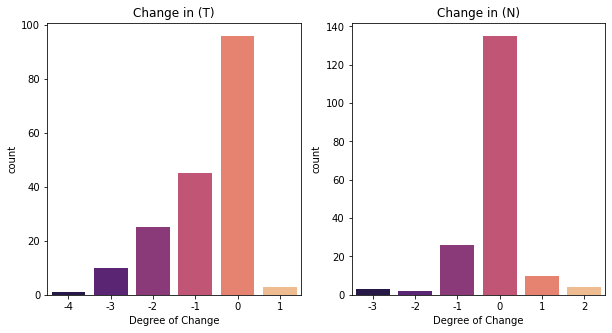

In [536]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

list_of_columns = [ "Change in (T)","Change in (N)"]


for i, column in enumerate(list_of_columns):
    sns.countplot(x = column, 
        ax=  ax[i],
        #hue = "Staging(Tumor Size)",
        data = data_na,
        palette = 'magma'
        )

    ax[i].set_title(column)
    ax[i].set_xlabel("Degree of Change")
    ax[i].set_ylabel("count")

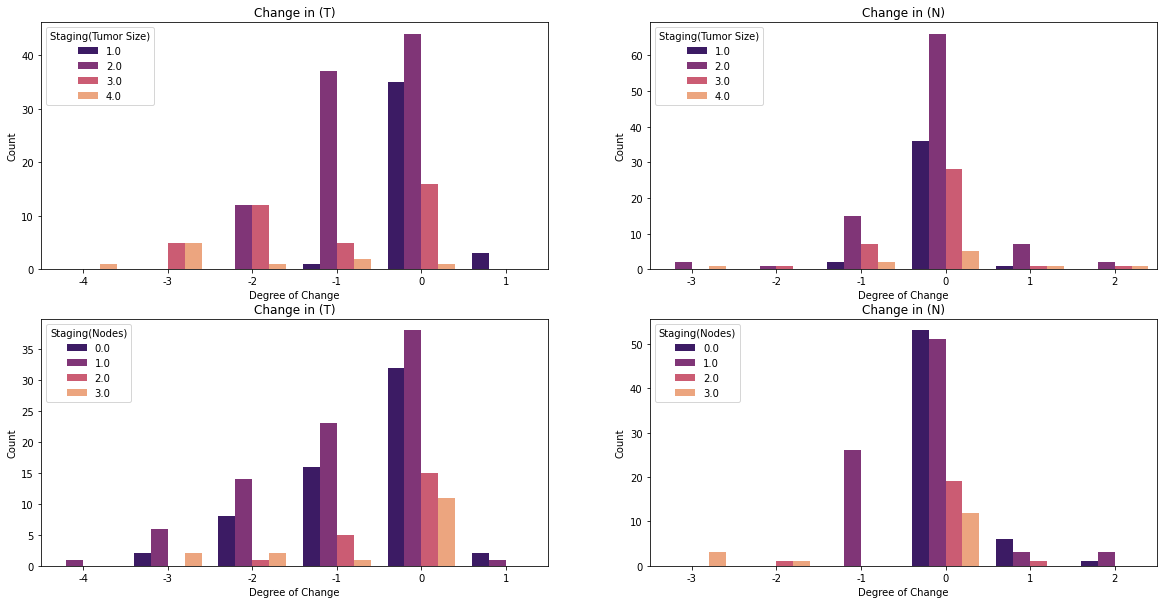

In [537]:
list_of_columns = ["Change in (T)", "Change in (N)", "Change in (T)", "Change in (N)"]
fig, ax = plt.subplots(2, 2, figsize = (20, 10))
ax = ax.flatten()
for i, column in enumerate(list_of_columns):
    if i == 0 or i == 1:
        hue_label = "Staging(Tumor Size)"
    else:
        hue_label = "Staging(Nodes)"

    
    sns.countplot(x = column, 
        ax=  ax[i],
        hue = hue_label,
        data = data_na,
        palette = 'magma'
        )

    ax[i].set_title(column)
    ax[i].set_xlabel("Degree of Change")
    ax[i].set_ylabel("Count")
    ax[i].legend(loc='upper left', title = hue_label)


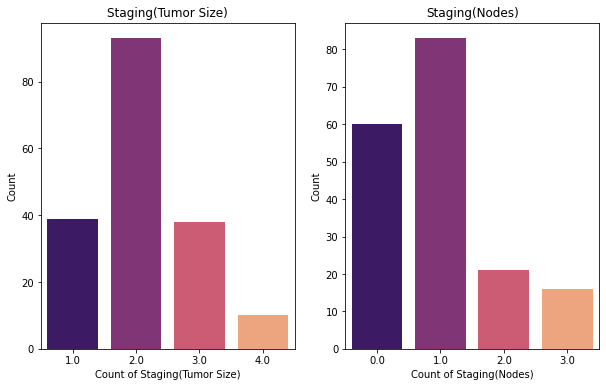

In [193]:
 list_of_columns = ["Staging(Tumor Size)","Staging(Nodes)"]
fig, ax = plt.subplots(1, 2, figsize = (10, 6))
ax = ax.flatten()

for i, column in enumerate(list_of_columns):
    sns.countplot(x = column, 
        ax=  ax[i],
        data = data_na,
        palette = 'magma'
        )

    ax[i].set_title(column)
    ax[i].set_xlabel(f"Count of {column}")
    ax[i].set_ylabel("Count")                                         

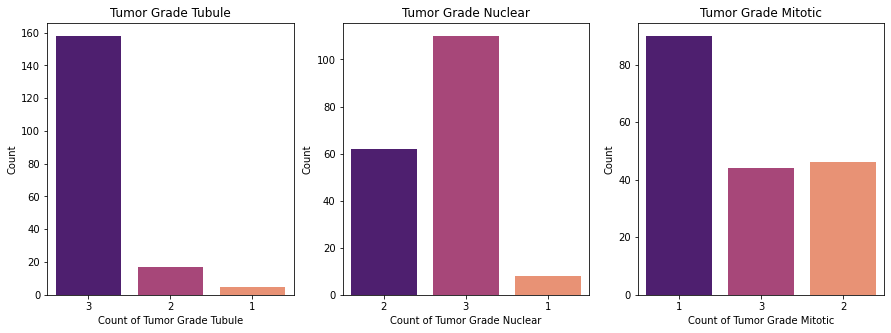

In [208]:
 list_of_columns = ["Tumor Grade Tubule", "Tumor Grade Nuclear" ,"Tumor Grade Mitotic"]
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
ax = ax.flatten()

for i, column in enumerate(list_of_columns):
    sns.countplot(x = column, 
        ax=  ax[i],
        data = data_na,
        palette = 'magma'
        )

    ax[i].set_title(column)
    ax[i].set_xlabel(f"Count of {column}")
    ax[i].set_ylabel("Count")                                         

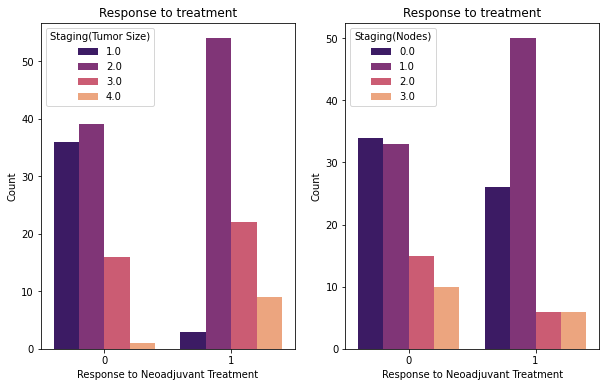

In [539]:
list_of_columns = ["Response to treatment","Response to treatment"]
fig, ax = plt.subplots(1, 2, figsize = (10, 6))
ax = ax.flatten()

for i, column in enumerate(list_of_columns):
    if i == 0:
        hue_label = "Staging(Tumor Size)"
    else:
        hue_label = "Staging(Nodes)"
    sns.countplot(x = column, 
        ax=  ax[i],
        hue = hue_label,
        data = data_na,
        palette = 'magma'
        )

    ax[i].set_title(column)
    ax[i].set_xlabel("Response to Neoadjuvant Treatment")
    ax[i].set_ylabel("Count")
    ax[i].legend(loc='upper left', title = hue_label)

### Below highlights how clinical features are distrubuted for those who do respond to treatment

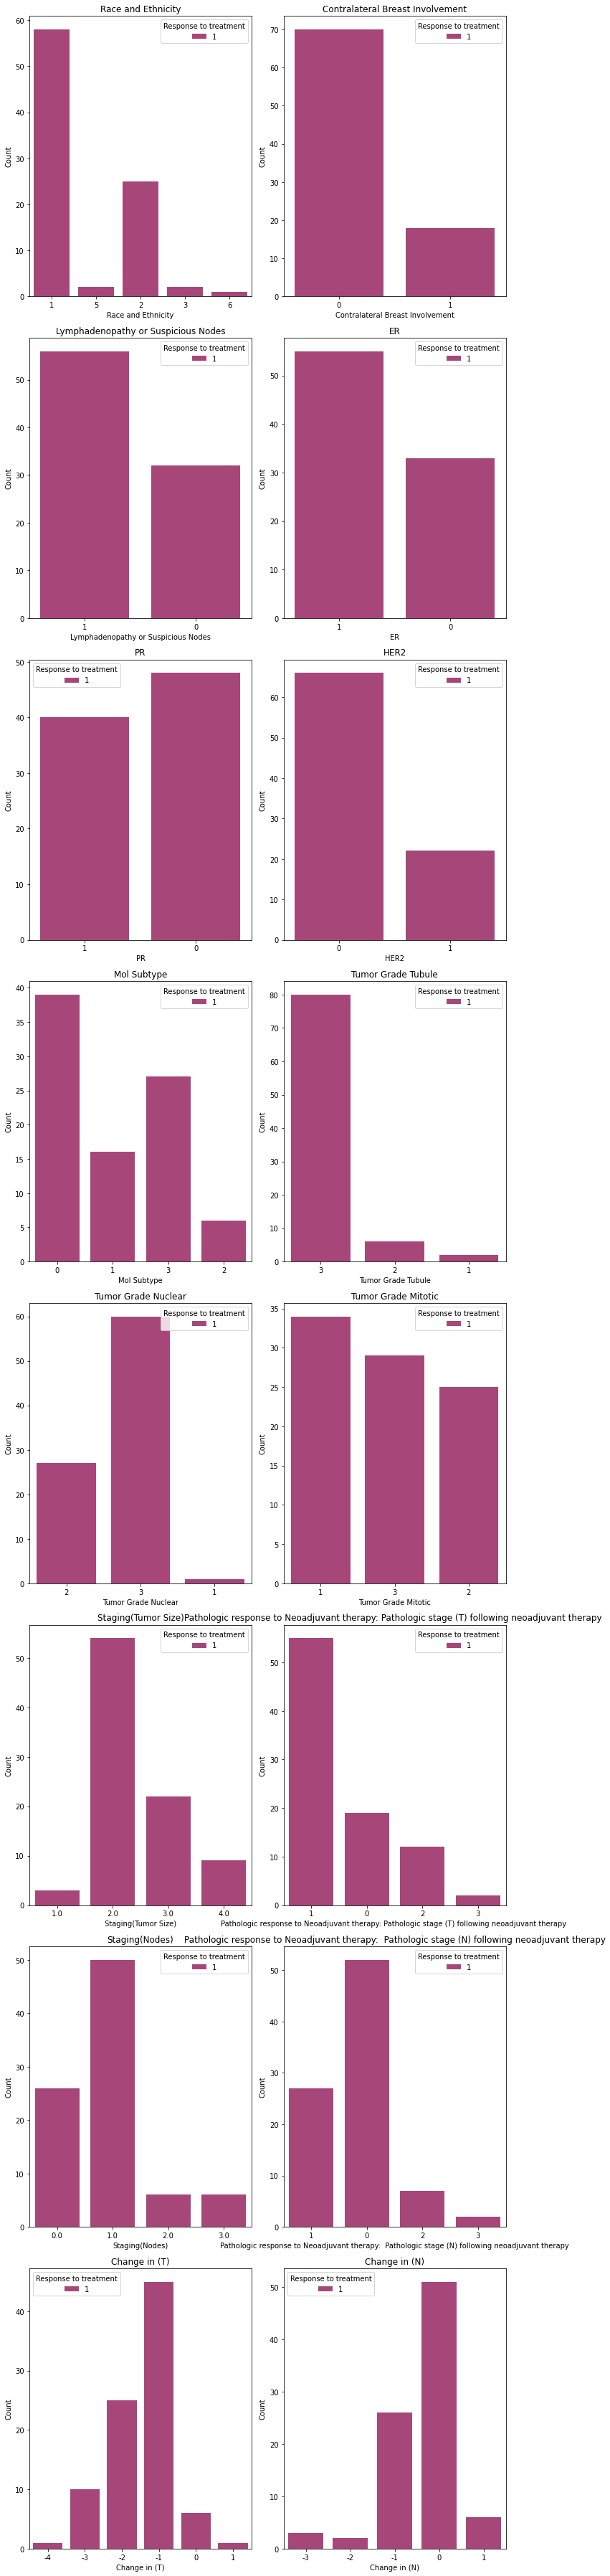

In [186]:
response_df = data_na.loc[data_na["Response to treatment"] == 1]

list_of_columns=response_df.columns

fig, ax = plt.subplots(8, 2, figsize = (10, 50))
ax = ax.flatten()

for i, column in enumerate(list_of_columns[2:18]):
    sns.countplot(x = column, 
        ax=  ax[i],
        hue ="Response to treatment",
        data = response_df,
        palette = 'magma'
        )

    ax[i].set_title(column)
    #ax[i].set_xlabel("Recurrence")
    ax[i].set_ylabel("Count")
    #ax[i].legend(loc='upper left', title = )
    
plt.tight_layout()

### Below the data for each feature is calculate as to what proportion of each element has response to treatment 

**An example there are only 10 cases of grade 1 tubular formation but from the redistrubuted graph that 40% had response similar to the other gradings of tubular formation. Infering that this feature might not be a good indicator of response to treatment.**

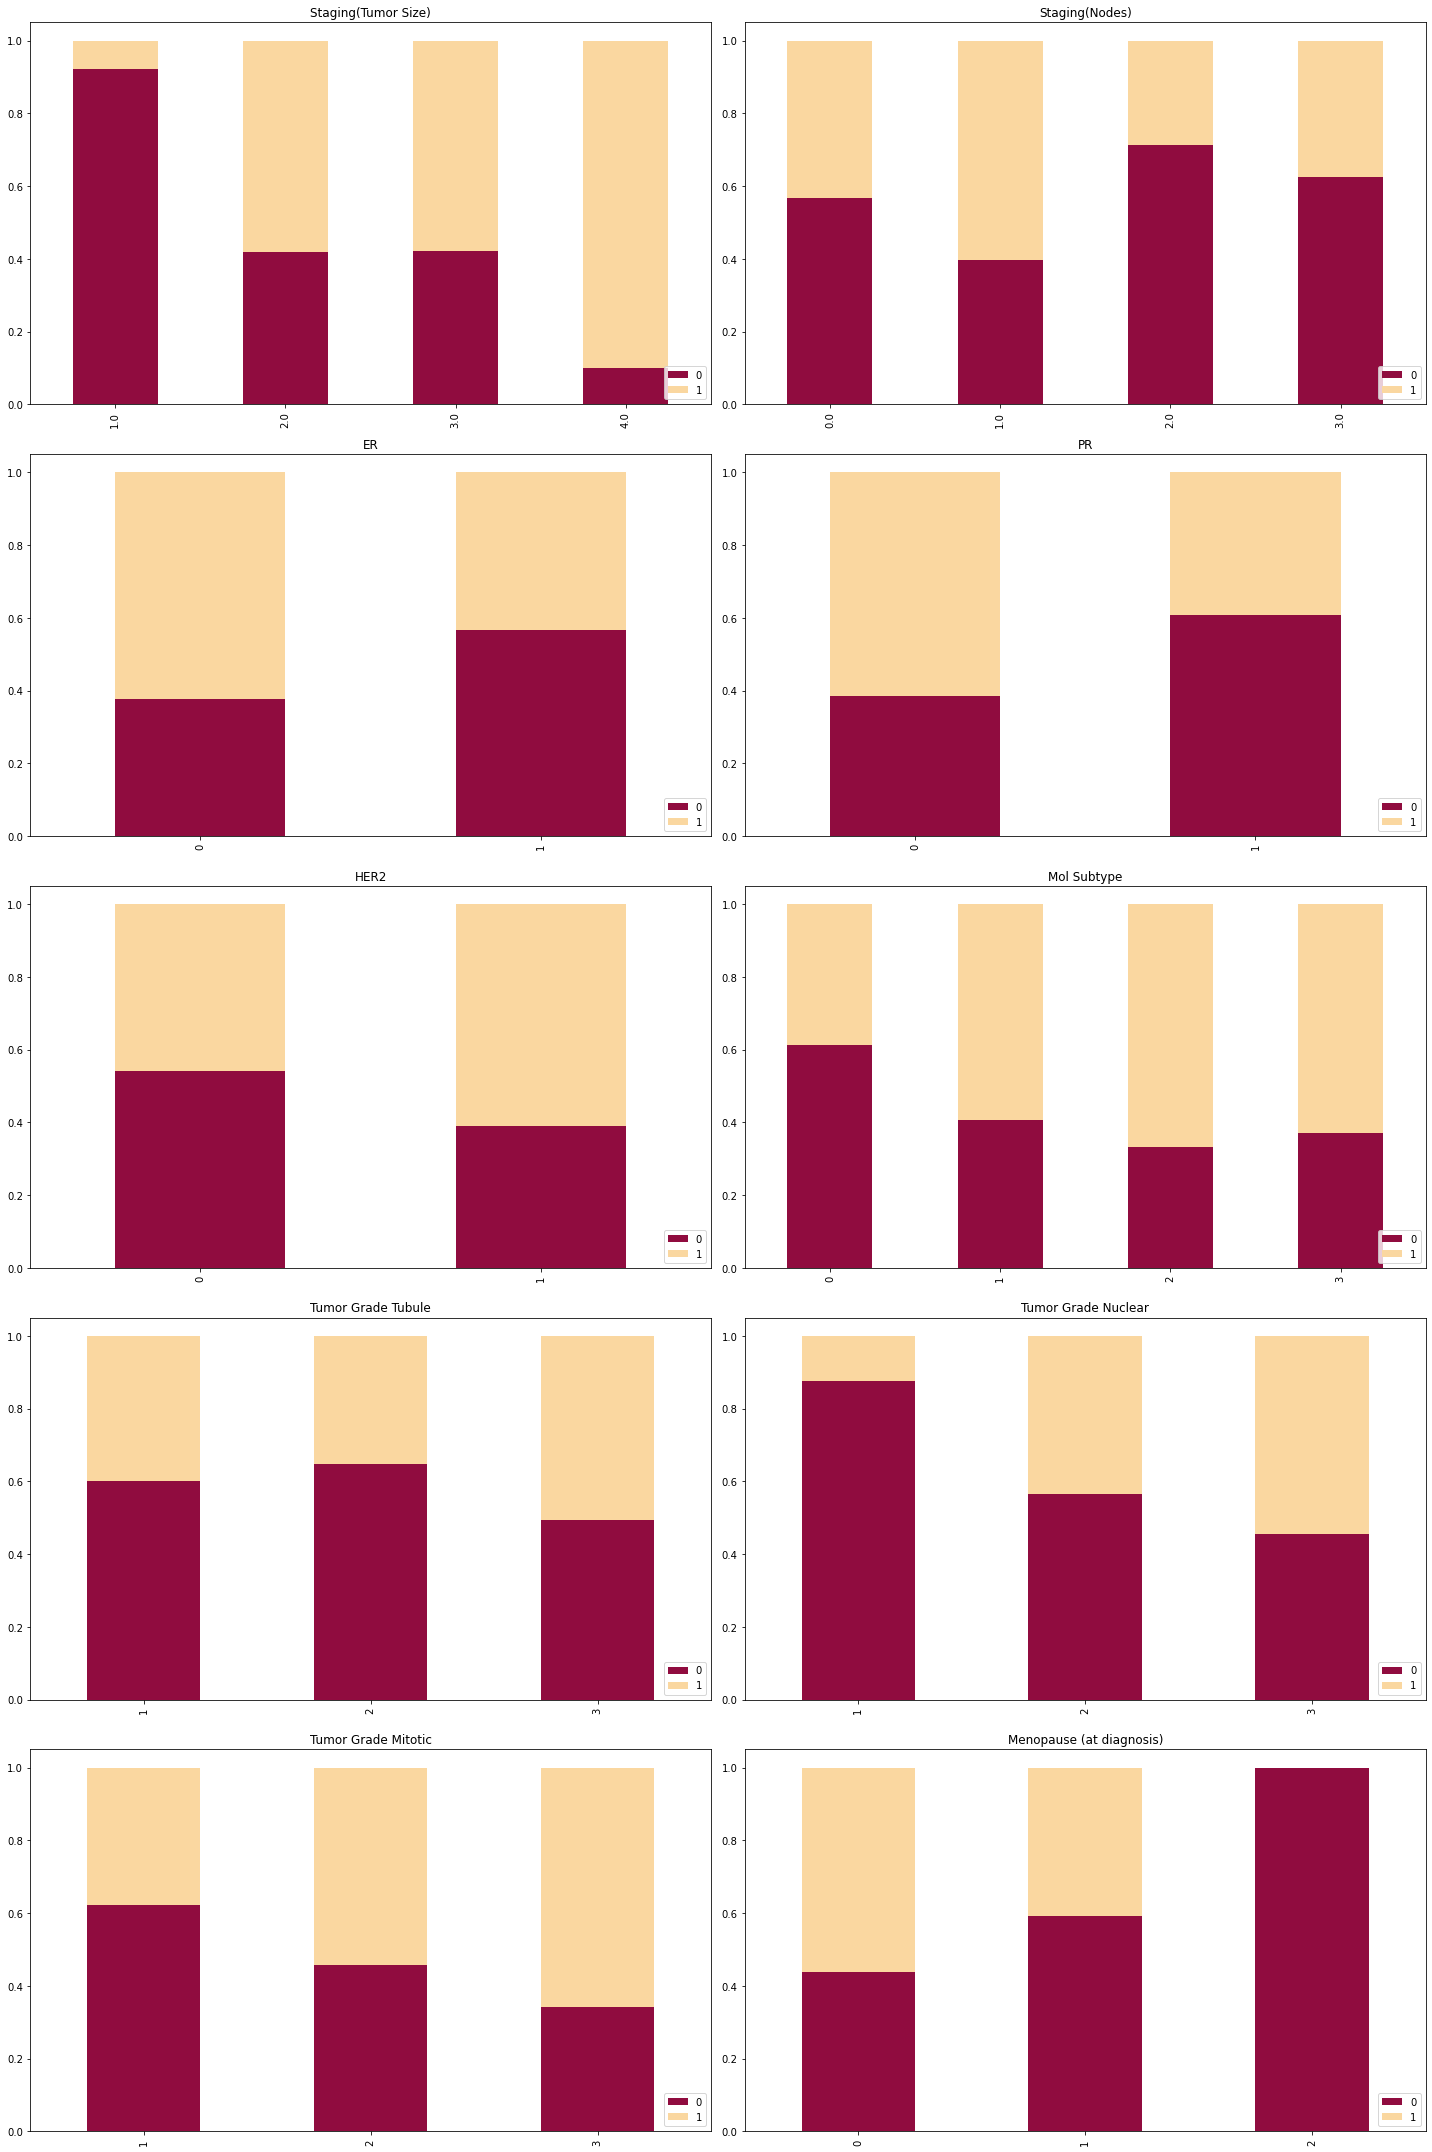

In [197]:
fig, ax = plt.subplots(5, 2, figsize = (20,30))
ax = ax.flatten()
list_of_columns = ['Staging(Tumor Size)', 'Staging(Nodes)', 'ER', 'PR','HER2', 'Mol Subtype', 
                   "Tumor Grade Tubule", "Tumor Grade Nuclear" ,"Tumor Grade Mitotic",'Menopause (at diagnosis)']

for i, column in enumerate(list_of_columns):

    cross_tab_prop = pd.crosstab(index=data_na[column],
                                 columns=data_na["Response to treatment"],
                                 normalize="index")

    cross_tab_prop.plot(kind='bar',
                        ax = ax[i],
                        stacked=True, 
                        colormap=ListedColormap(sns.color_palette(['#900C3F', '#FAD7A0']))
                       )

    ax[i].set_title(column)
    ax[i].set_xlabel("")
    ax[i].legend(loc='lower right')
    

plt.tight_layout()
#fig.suptitle("Proportion of Cases with response to Neoadjuvant Treatment")
plt.show()

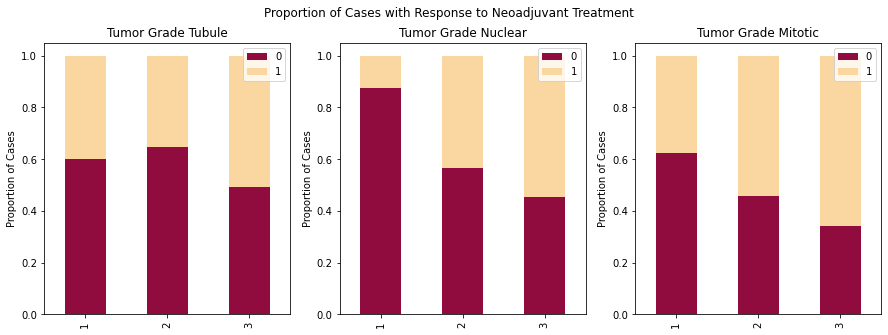

In [204]:
fig, ax = plt.subplots(1, 3, figsize = (15,5))
ax = ax.flatten()
list_of_columns = ["Tumor Grade Tubule", "Tumor Grade Nuclear" ,"Tumor Grade Mitotic"]

for i, column in enumerate(list_of_columns):

    cross_tab_prop = pd.crosstab(index=data_na[column],
                                 columns=data_na["Response to treatment"],
                                 normalize="index")

    cross_tab_prop.plot(kind='bar',
                        ax = ax[i],
                        stacked=True, 
                        colormap=ListedColormap(sns.color_palette(['#900C3F', '#FAD7A0']))
                       )

    ax[i].set_title(column)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("Proportion of Cases")
    ax[i].legend(loc='upper right')
    

#plt.tight_layout()
fig.suptitle("Proportion of Cases with Response to Neoadjuvant Treatment")
plt.show()

## Further preprocessing steps - One-hot-encode Categorical Data

In [259]:
mol_dict ={"0" : "Luminal A", 
             "1" : "Luminal B",
             "2" : "HER2",
             "3" : "Triple Negative"}

df_mol = data_na.replace({"Mol Subtype": mol_dict})

Text(0.5, 0.98, 'Distrubution of Molecular Subtype')

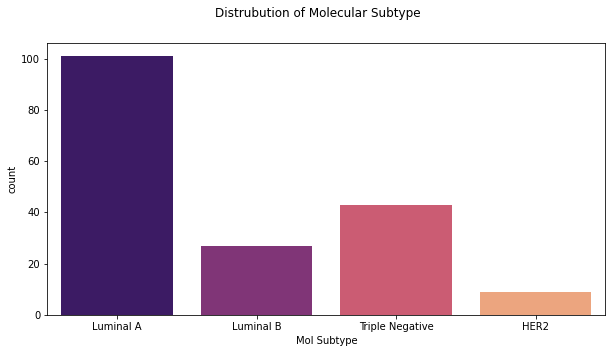

In [187]:
plt.figure(figsize=(10,5))
sns.countplot(x = "Mol Subtype",
        data = df_mol,
        #hue = "Recurrence event(s)",
        palette = 'magma'
        )
plt.suptitle("Distrubution of Molecular Subtype")

Text(0.5, 0.98, 'Distrubution of Molecular Subtype')

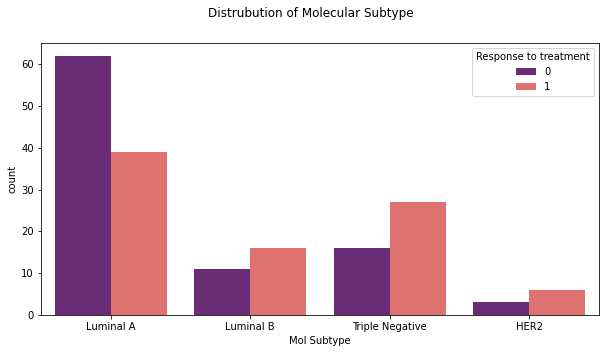

In [189]:
plt.figure(figsize=(10,5))
sns.countplot(x = "Mol Subtype",
        data = df_mol,
        hue = "Response to treatment",
        palette = 'magma'
        )
plt.suptitle("Distrubution of Molecular Subtype")

In [260]:
col_ohe = pd.get_dummies(df_mol["Mol Subtype"], prefix="Mol Subtype")
mol_data = pd.concat((df_mol, col_ohe), axis=1).drop("Mol Subtype", axis=1)

In [261]:
race_dict = {"0" : "NaN", 
             "1" : "White",
             "2" : "Black",
             "3" : "Asian",
             "4" : "Native",
             "5" : "Hispanic",
             "6" : "Multi",
             "7" : "Hawa",
             "8" : "American Indian"}
df_race = mol_data.replace({"Race and Ethnicity": race_dict})
df_race.head()

,Date of Birth (Days),Menopause (at diagnosis),Race and Ethnicity,Contralateral Breast Involvement,Lymphadenopathy or Suspicious Nodes,ER,PR,HER2,Tumor Grade Tubule,Tumor Grade Nuclear,...,Pathologic response to Neoadjuvant therapy: Pathologic stage (T) following neoadjuvant therapy,Staging(Nodes),Pathologic response to Neoadjuvant therapy: Pathologic stage (N) following neoadjuvant therapy,Change in (T),Change in (N),Response to treatment,Mol Subtype_HER2,Mol Subtype_Luminal A,Mol Subtype_Luminal B,Mol Subtype_Triple Negative
3,-22685,1,White,0,1,1,1,0,3,2,...,1,1.0,1,-1,0,1,0,1,0,0
5,-13932,0,Hispanic,0,1,1,0,1,3,3,...,0,1.0,0,-2,-1,1,0,0,1,0
10,-24712,1,White,0,1,0,0,0,3,3,...,2,2.0,2,-1,0,1,0,0,0,1
12,-15885,0,Black,0,1,0,0,0,3,3,...,2,2.0,2,0,0,0,0,0,0,1
19,-13100,0,White,0,0,1,1,0,3,2,...,1,1.0,1,0,0,0,0,1,0,0


Text(0.5, 0.98, 'Distrubution of Race and Ethinicity')

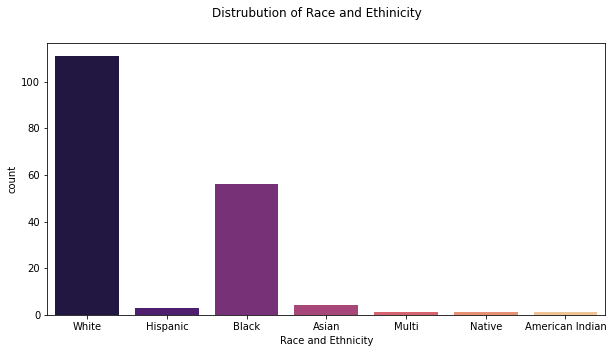

In [211]:
plt.figure(figsize=(10,5))
sns.countplot(x = "Race and Ethnicity",
        data = df_race,
        #hue = "Recurrence event(s)",
        palette = 'magma'
        )
plt.suptitle("Distrubution of Race and Ethinicity")

In [215]:
df_race = df_race[df_race['Race and Ethnicity'].str.contains('NaN') == False]

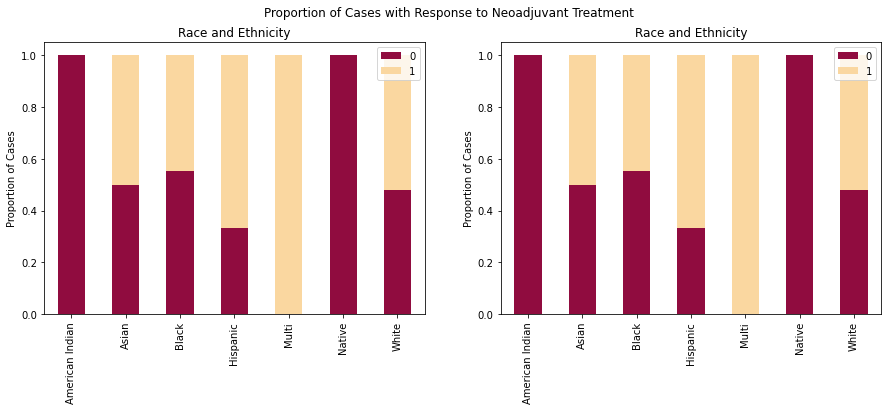

In [226]:
fig, ax = plt.subplots(1, 2, figsize = (15,5))
#ax = ax.flatten()
list_of_columns = ['Race and Ethnicity','Race and Ethnicity']

for i, column in enumerate(list_of_columns):

    cross_tab_prop = pd.crosstab(index=df_race[column],
                                 columns=df_race["Response to treatment"],
                                 normalize="index")

    cross_tab_prop.plot(kind='bar',
                        ax = ax[i],
                        stacked=True, 
                        colormap=ListedColormap(sns.color_palette(['#900C3F', '#FAD7A0']))
                       )

    ax[i].set_title(column)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("Proportion of Cases")
    ax[i].legend(loc='upper right')
    

#plt.tight_layout()
fig.suptitle("Proportion of Cases with Response to Neoadjuvant Treatment")
plt.show()

In [262]:
col_ohe = pd.get_dummies(df_race["Race and Ethnicity"], prefix="Race and Ethnicity")
full_data = pd.concat((df_race, col_ohe), axis=1).drop("Race and Ethnicity", axis=1)
full_data.head()

,Date of Birth (Days),Menopause (at diagnosis),Contralateral Breast Involvement,Lymphadenopathy or Suspicious Nodes,ER,PR,HER2,Tumor Grade Tubule,Tumor Grade Nuclear,Tumor Grade Mitotic,...,Mol Subtype_Luminal B,Mol Subtype_Triple Negative,Race and Ethnicity_American Indian,Race and Ethnicity_Asian,Race and Ethnicity_Black,Race and Ethnicity_Hispanic,Race and Ethnicity_Multi,Race and Ethnicity_NaN,Race and Ethnicity_Native,Race and Ethnicity_White
3,-22685,1,0,1,1,1,0,3,2,1,...,0,0,0,0,0,0,0,0,0,1
5,-13932,0,0,1,1,0,1,3,3,3,...,1,0,0,0,0,1,0,0,0,0
10,-24712,1,0,1,0,0,0,3,3,2,...,0,1,0,0,0,0,0,0,0,1
12,-15885,0,0,1,0,0,0,3,3,3,...,0,1,0,0,1,0,0,0,0,0
19,-13100,0,0,0,1,1,0,3,2,1,...,0,0,0,0,0,0,0,0,0,1


In [263]:
full_data['Date of Birth (Days)'] = full_data['Date of Birth (Days)'].map(lambda x: x.lstrip('-'))

In [264]:
full_data =full_data.loc[full_data['Menopause (at diagnosis)'] != "2"]

In [265]:
print(len(full_data))

179


In [266]:
full_data.columns

Index(['Date of Birth (Days)', 'Menopause (at diagnosis)',
       'Contralateral Breast Involvement',
       'Lymphadenopathy or Suspicious Nodes', 'ER', 'PR', 'HER2',
       'Tumor Grade Tubule', 'Tumor Grade Nuclear', 'Tumor Grade Mitotic',
       'Staging(Tumor Size)',
       'Pathologic response to Neoadjuvant therapy: Pathologic stage (T) following neoadjuvant therapy ',
       'Staging(Nodes)',
       'Pathologic response to Neoadjuvant therapy:  Pathologic stage (N) following neoadjuvant therapy',
       'Change in (T)', 'Change in (N)', 'Response to treatment',
       'Mol Subtype_HER2', 'Mol Subtype_Luminal A', 'Mol Subtype_Luminal B',
       'Mol Subtype_Triple Negative', 'Race and Ethnicity_American Indian',
       'Race and Ethnicity_Asian', 'Race and Ethnicity_Black',
       'Race and Ethnicity_Hispanic', 'Race and Ethnicity_Multi',
       'Race and Ethnicity_NaN', 'Race and Ethnicity_Native',
       'Race and Ethnicity_White'],
      dtype='object')

In [232]:
columns = full_data.columns
for column in columns[1:]:
    print(column)
    print(full_data[column].value_counts())

Menopause (at diagnosis)
0    97
1    79
Name: Menopause (at diagnosis), dtype: int64
Contralateral Breast Involvement
0    143
1     33
Name: Contralateral Breast Involvement, dtype: int64
Lymphadenopathy or Suspicious Nodes
1    107
0     69
Name: Lymphadenopathy or Suspicious Nodes, dtype: int64
ER
1    123
0     53
Name: ER, dtype: int64
PR
1    98
0    78
Name: PR, dtype: int64
HER2
0    140
1     36
Name: HER2, dtype: int64
Tumor Grade Tubule
3    154
2     17
1      5
Name: Tumor Grade Tubule, dtype: int64
Tumor Grade Nuclear
3    106
2     62
1      8
Name: Tumor Grade Nuclear, dtype: int64
Tumor Grade Mitotic
1    89
2    45
3    42
Name: Tumor Grade Mitotic, dtype: int64
Staging(Tumor Size)
2.0    92
3.0    38
1.0    36
4.0    10
Name: Staging(Tumor Size), dtype: int64
Pathologic response to Neoadjuvant therapy: Pathologic stage (T) following neoadjuvant therapy 
1    86
2    52
0    19
3    18
4     1
Name: Pathologic response to Neoadjuvant therapy: Pathologic stage (T) fol

In [267]:
full_data2 = full_data.drop(["Change in (N)", "Change in (T)",
                             'Pathologic response to Neoadjuvant therapy:  Pathologic stage (N) following neoadjuvant therapy',
                            'Pathologic response to Neoadjuvant therapy: Pathologic stage (T) following neoadjuvant therapy '
                            ], axis = 1)

In [268]:
num_data = full_data2.apply(pd.to_numeric)

In [269]:
num_data.describe()

,Date of Birth (Days),Menopause (at diagnosis),Contralateral Breast Involvement,Lymphadenopathy or Suspicious Nodes,ER,PR,HER2,Tumor Grade Tubule,Tumor Grade Nuclear,Tumor Grade Mitotic,...,Mol Subtype_Luminal B,Mol Subtype_Triple Negative,Race and Ethnicity_American Indian,Race and Ethnicity_Asian,Race and Ethnicity_Black,Race and Ethnicity_Hispanic,Race and Ethnicity_Multi,Race and Ethnicity_NaN,Race and Ethnicity_Native,Race and Ethnicity_White
count,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,...,179.000000,179.000000,179.000000,179.000000,179.000000,179.00000,179.000000,179.00000,179.000000,179.000000
mean,18369.938547,0.452514,0.195531,0.603352,0.703911,0.564246,0.201117,2.849162,2.564246,1.743017,...,0.150838,0.240223,0.005587,0.022346,0.312849,0.01676,0.005587,0.01676,0.005587,0.614525
std,4056.470469,0.499136,0.397721,0.490574,0.457811,0.497246,0.401960,0.430099,0.580639,0.828491,...,0.358895,0.428417,0.074744,0.148222,0.464954,0.12873,0.074744,0.12873,0.074744,0.488073
min,10183.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000
25%,15416.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000
50%,17805.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,3.000000,3.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,1.000000
75%,20624.500000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,3.000000,3.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.00000,0.000000,1.000000
max,26902.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,3.000000,3.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.00000,1.000000,1.000000


# Features of Importance (SHAP values)

In [252]:
y = num_data[['Response to treatment']]
X = num_data.drop(['Response to treatment'], axis = 1)
X.head()

,Date of Birth (Days),Menopause (at diagnosis),Contralateral Breast Involvement,Lymphadenopathy or Suspicious Nodes,ER,PR,HER2,Tumor Grade Tubule,Tumor Grade Nuclear,Tumor Grade Mitotic,...,Mol Subtype_her2,Mol Subtype_luminal-like,Mol Subtype_trip neg,Race and Ethnicity_American Indian,Race and Ethnicity_Asian,Race and Ethnicity_Black,Race and Ethnicity_Hispanic,Race and Ethnicity_Multi,Race and Ethnicity_Native,Race and Ethnicity_White
3,22685,1,0,1,1,1,0,3,2,1,...,0,1,0,0,0,0,0,0,0,1
5,13932,0,0,1,1,0,1,3,3,3,...,0,0,0,0,0,0,1,0,0,0
10,24712,1,0,1,0,0,0,3,3,2,...,0,0,1,0,0,0,0,0,0,1
12,15885,0,0,1,0,0,0,3,3,3,...,0,0,1,0,0,1,0,0,0,0
19,13100,0,0,0,1,1,0,3,2,1,...,0,1,0,0,0,0,0,0,0,1


In [245]:
scaler = preprocessing.StandardScaler()
X= scaler.fit_transform(X)

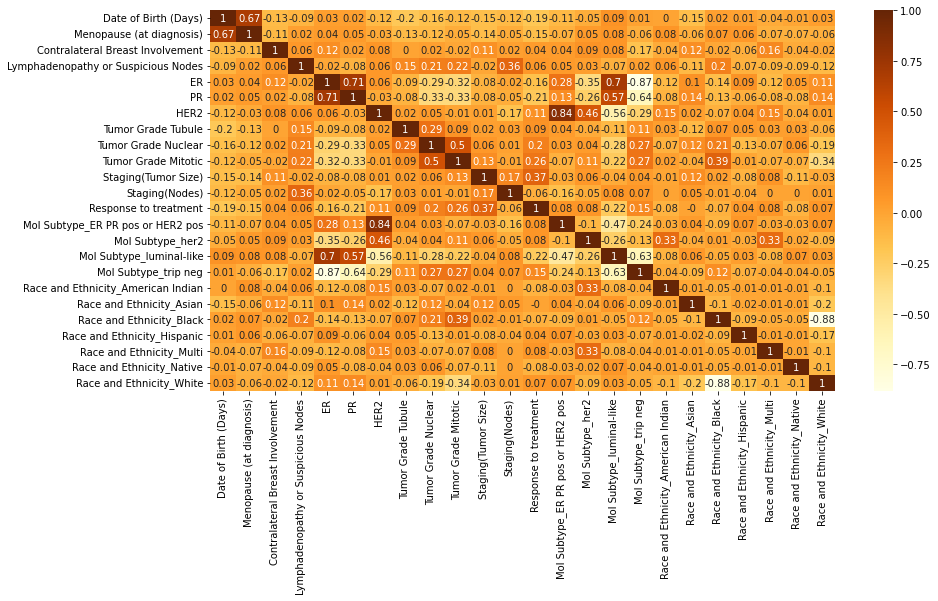

In [246]:
def heat_map(data):
    correlation = data.corr().round(2)
    plt.figure(figsize = (14,7))
    sns.heatmap(correlation, annot = True, cmap = 'YlOrBr')
    plt.show()
    
heat_map(num_data)

In [17]:
#common error with Shap make sure feature names are in a suitble format
#X.columns[X.columns.str.contains("[\[\]<,]")]

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


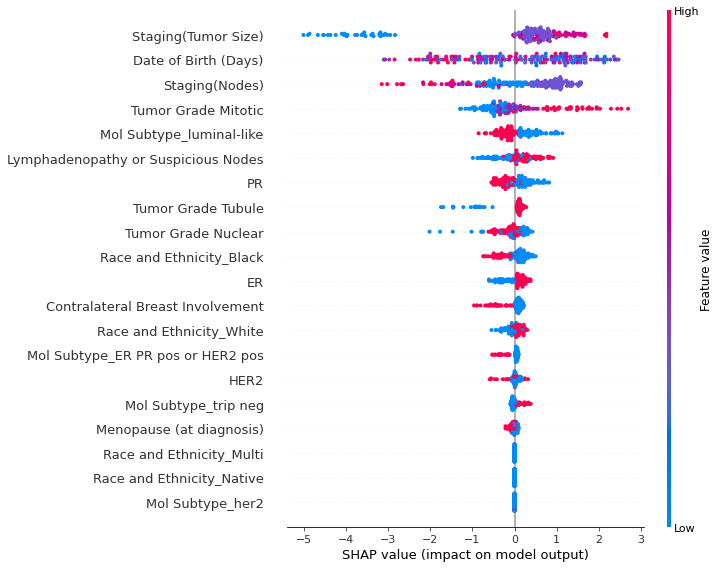

In [253]:
model = XGBClassifier()
model.fit(X, y)
shap.initjs()

shap_explainer = shap.TreeExplainer(model)
shap_values = shap_explainer.shap_values(X)
shap.summary_plot(shap_values, X)

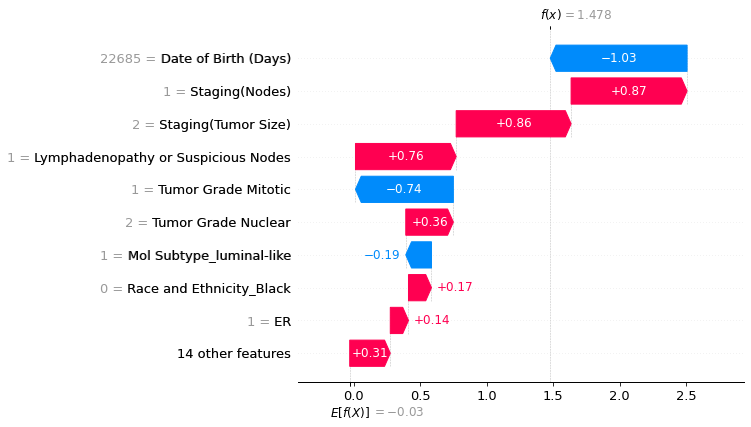

In [254]:
explainer = shap.Explainer(model, X)
shap_values = explainer(X)
shap.plots.waterfall(shap_values[0])

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


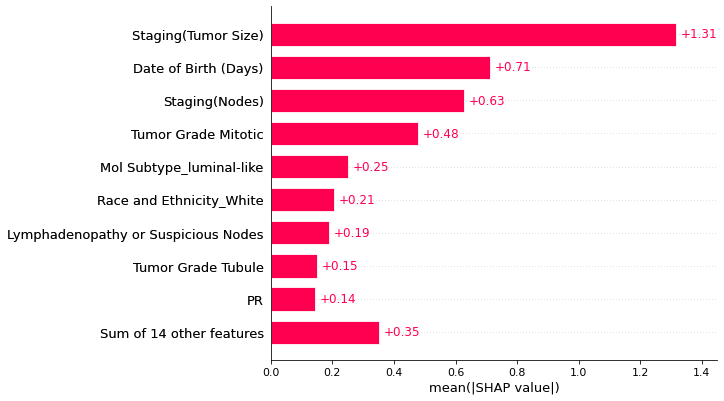

In [255]:
#train XGBoost model
model = XGBClassifier(n_estimators=100, max_depth=2).fit(X, y, eval_metric="logloss")
background_X = shap.maskers.Independent(X, max_samples=100)
# compute SHAP values
explainer = shap.Explainer(model, background_X)
shap_values = explainer(X)

shap.plots.bar(shap_values)

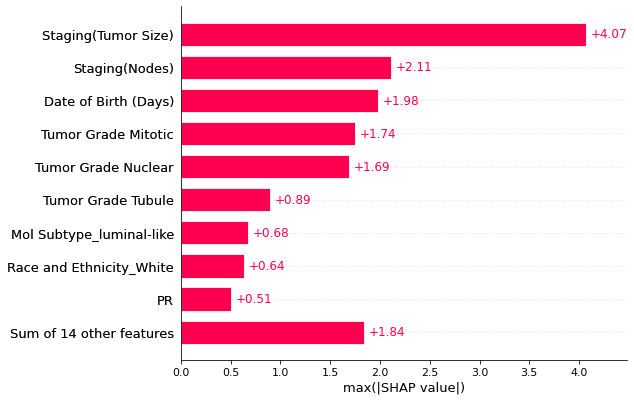

In [256]:
shap.plots.bar(shap_values.abs.max(0))

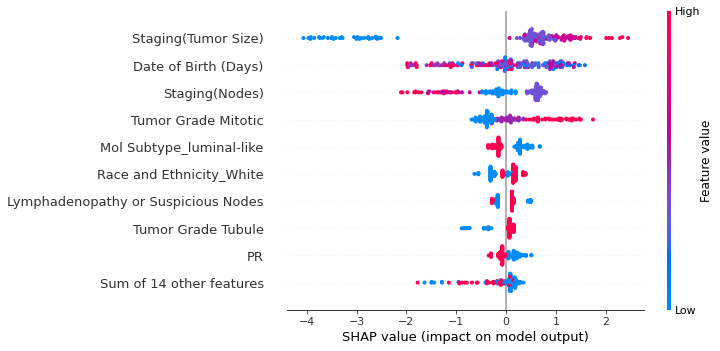

In [257]:
shap.plots.beeswarm(shap_values)

# Neural Network

## Test Train 

**After consideration of our data analysis and SHAP values a few different varriations of feature selected data were tried, below is the selection that provided the best results.**

In [271]:
feature_selected_data = num_data[['Staging(Tumor Size)','Date of Birth (Days)', 'Staging(Nodes)' , 'Tumor Grade Mitotic',
                                  'Mol Subtype_Luminal A', 'Lymphadenopathy or Suspicious Nodes','Tumor Grade Tubule',
                                 'PR', 'Tumor Grade Nuclear', 'Response to treatment']]
feature_selected_data.head()

,Staging(Tumor Size),Date of Birth (Days),Staging(Nodes),Tumor Grade Mitotic,Mol Subtype_Luminal A,Lymphadenopathy or Suspicious Nodes,Tumor Grade Tubule,PR,Tumor Grade Nuclear,Response to treatment
3,2.0,22685,1.0,1,1,1,3,1,2,1
5,2.0,13932,1.0,3,0,1,3,0,3,1
10,3.0,24712,2.0,2,0,1,3,0,3,1
12,2.0,15885,2.0,3,0,1,3,0,3,0
19,1.0,13100,1.0,1,1,0,3,1,2,0


In [272]:
def test_train_dataset(data, split_size, label):

    train_df, test_df = train_test_split(data, test_size=split_size, random_state=42)
    print(train_df.columns)
    
    # Form np arrays of labels and features.
    y_train = np.array(train_df.pop(label))
    y_test = np.array(test_df.pop(label))

    X_train = np.array(train_df)
    X_test = np.array(test_df)
    
    return X_train, X_test, y_train, y_test

In [273]:
X_train, X_test, y_train, y_test = test_train_dataset(feature_selected_data, 0.3, 'Response to treatment')

Index(['Staging(Tumor Size)', 'Date of Birth (Days)', 'Staging(Nodes)',
       'Tumor Grade Mitotic', 'Mol Subtype_Luminal A',
       'Lymphadenopathy or Suspicious Nodes', 'Tumor Grade Tubule', 'PR',
       'Tumor Grade Nuclear', 'Response to treatment'],
      dtype='object')


In [274]:
scaler = preprocessing.StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Rebalancing Class Weights

In [277]:
org_size = collections.Counter(y_train) 
print(org_size)
print(collections.Counter(y_test))

Counter({0: 66, 1: 59})
Counter({1: 29, 0: 25})


In [276]:
org_size = collections.Counter(y_train) 

n_classes= 2 
n_sample0= int(org_size.get(0))
n_sample1= int(org_size.get(1))
n_samples= n_sample0 + n_sample1
    

#Weights for class 0 (no response):
w0=  n_samples/(n_classes*n_sample0) 

#Weights for class 1 (complete or partial response):
w1= n_samples/(n_classes*n_sample1)

class_weights = {0:w0*2, 1: w1*2}
print(org_size)
print(class_weights)

Counter({0: 66, 1: 59})
{0: 1.893939393939394, 1: 2.1186440677966103}


### Define the Model 

In [278]:
BATCH_SIZE = 32

input_shape = X_train.shape[1]
print(input_shape)

9


**Note variations in number of neurons and regularization techniques were tried, it was found this version to be the most effective to avoid overfitting due to the small nature of the dataset. As our data is suplemented, a more complex model may be better suited**

In [279]:
img_input = Input(shape=(input_shape, ))

x = Dense(64, activation = "relu")(img_input)
x = Dense(128, activation = "relu")(x)
x = Dropout(0.2)(x)
x = Dense(64, activation = "relu")(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation = "sigmoid")(x)

model = Model(inputs = img_input, outputs = predictions)

In [280]:
model.summary()
"""tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)"""

Model: "model_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_40 (InputLayer)       [(None, 9)]               0         
                                                                 
 dense_152 (Dense)           (None, 64)                640       
                                                                 
 dense_153 (Dense)           (None, 128)               8320      
                                                                 
 dropout_76 (Dropout)        (None, 128)               0         
                                                                 
 dense_154 (Dense)           (None, 64)                8256      
                                                                 
 dropout_77 (Dropout)        (None, 64)                0         
                                                                 
 dense_155 (Dense)           (None, 1)                 65 

'tf.keras.utils.plot_model(\n    model,\n    show_shapes=True,\n    show_layer_names=True,\n    rankdir="TB",\n    expand_nested=True,\n    dpi=96,\n)'

In [150]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR')
]

In [151]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate = 0.01),
              loss='binary_crossentropy',
              metrics= METRICS)

In [152]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "clinical_classification.h5", save_best_only=True
)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                           mode='min', 
                                           patience=5, 
                                           restore_best_weights =True)

## Run the Model

In [153]:
history = model.fit(X_train,
                    y_train,
                    batch_size= BATCH_SIZE,
                    validation_data = (X_test, y_test), 
                    #class_weight =class_weights,
                    callbacks=[checkpoint_cb, early_stop],
                    verbose = 1,
                    epochs=80)

Epoch 1/80
4/4 [==============================] - 2s 249ms/step - loss: 0.6789 - tp: 23.0000 - fp: 21.0000 - tn: 41.0000 - fn: 38.0000 - accuracy: 0.5203 - precision: 0.5227 - recall: 0.3770 - auc: 0.5849 - prc: 0.5811 - val_loss: 0.5814 - val_tp: 16.0000 - val_fp: 5.0000 - val_tn: 21.0000 - val_fn: 11.0000 - val_accuracy: 0.6981 - val_precision: 0.7619 - val_recall: 0.5926 - val_auc: 0.7785 - val_prc: 0.8093
Epoch 2/80
4/4 [==============================] - 0s 28ms/step - loss: 0.6047 - tp: 39.0000 - fp: 21.0000 - tn: 41.0000 - fn: 22.0000 - accuracy: 0.6504 - precision: 0.6500 - recall: 0.6393 - auc: 0.7306 - prc: 0.7041 - val_loss: 0.5605 - val_tp: 16.0000 - val_fp: 4.0000 - val_tn: 22.0000 - val_fn: 11.0000 - val_accuracy: 0.7170 - val_precision: 0.8000 - val_recall: 0.5926 - val_auc: 0.8034 - val_prc: 0.8271
Epoch 3/80
4/4 [==============================] - 0s 24ms/step - loss: 0.5480 - tp: 43.0000 - fp: 19.0000 - tn: 43.0000 - fn: 18.0000 - accuracy: 0.6992 - precision: 0.6935 - 

# Model Evaluation

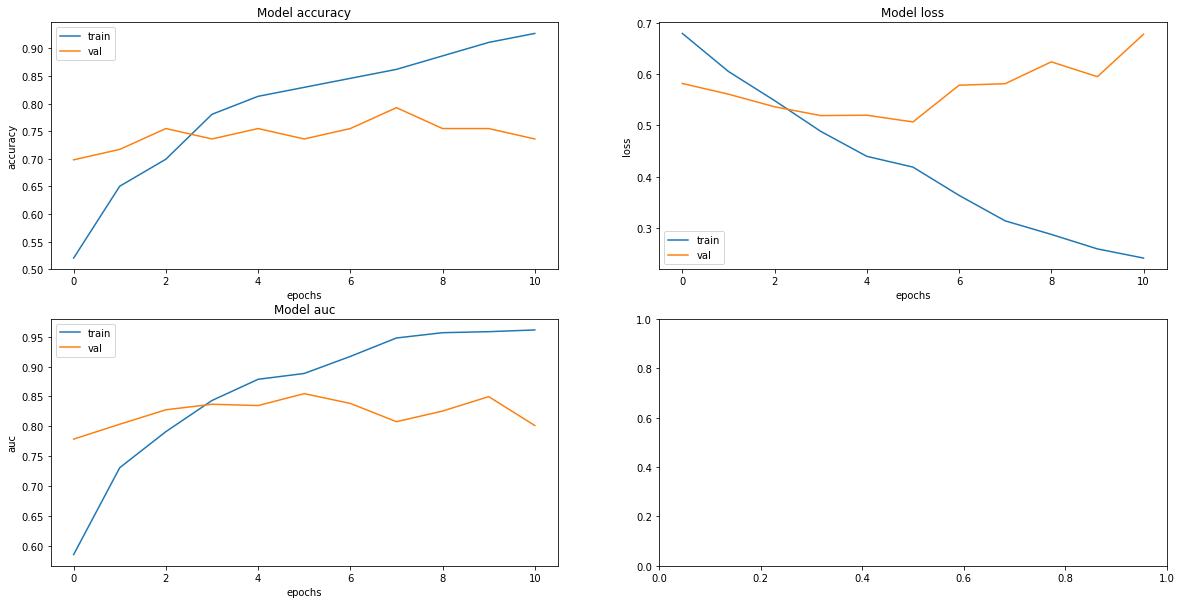

In [154]:
def plot_metrics(list_of_metrics):
    
    rows = int(np.ceil(len(list_of_metrics)/2))
    columns = 2
    
    fig, ax = plt.subplots(rows, columns, figsize=(20, 10))
    ax = ax.ravel()

    for i, metric in enumerate(list_of_metrics):
        ax[i].plot(history.history[metric])
        ax[i].plot(history.history["val_" + metric])
        ax[i].set_title("Model {}".format(metric))
        ax[i].set_xlabel("epochs")
        ax[i].set_ylabel(metric)
        ax[i].legend(["train", "val"])

plot_metrics(["accuracy", "loss", "auc"])

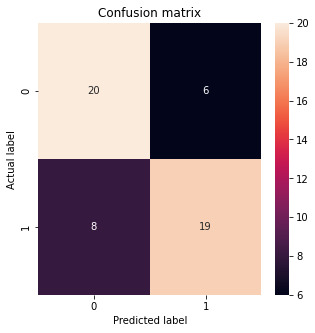

In [155]:
def plot_cm(labels, predictions, p=0.5):
    
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
test_predictions_baseline = model.predict(X_test, batch_size=BATCH_SIZE)
plot_cm(y_test, test_predictions_baseline)

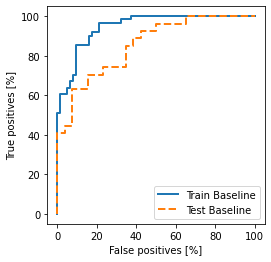

In [156]:
def plot_roc(name, labels, predictions, **kwargs):
      
    fp, tp, _ = roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    #plt.xlim([-0.5,20])
    #plt.ylim([80,100.5])
    ax = plt.gca()
    ax.set_aspect('equal')
        
train_predictions_baseline = model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(X_test, batch_size=BATCH_SIZE)

plot_roc("Train Baseline", y_train, train_predictions_baseline)
plot_roc("Test Baseline", y_test, test_predictions_baseline, linestyle='--')
plt.legend(loc='lower right')

In [157]:
def print_total_results(model, X_test, y_test):
    baseline_results = model.evaluate(X_test, y_test,
                                      batch_size=BATCH_SIZE, verbose=0)
    for name, value in zip(model.metrics_names, baseline_results):
        print(name, ': ', value)

print_total_results(model, X_test, y_test)

loss :  0.5063751339912415
tp :  19.0
fp :  6.0
tn :  20.0
fn :  8.0
accuracy :  0.7358490824699402
precision :  0.7599999904632568
recall :  0.7037037014961243
auc :  0.8547008633613586
prc :  0.8728699684143066


In [81]:
model.load_weights("clinical_classification.h5")
prediction = model.predict(np.expand_dims(X_test[0], axis=0))[0]
print("Actual :", y_test[0])
scores = [1 - prediction[0], prediction[0]]

class_names = ["no response", "response"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that the patient would have %s to neoadjuvant treatment"
        % ((100 * score), name)
    )

Actual : 1
This model is 20.81 percent confident that the patient would have no response to neoadjuvant treatment
This model is 79.19 percent confident that the patient would have response to neoadjuvant treatment


# Hyperparameter Tuning

**To see if we can improve upon our very simple neural network (which was made in such a manner to prevent overfitting) we will also try Keras Hyperparameter tuning module**

In [43]:
LOG_DIR = "Hyperparameter_Tuning"

In [42]:
BATCH_SIZE = 32

input_shape = X_train.shape[1]
img_input = Input(shape=(input_shape, ))
print(input_shape)

10


In [63]:
def model_builder(hp):
    
    img_input = Input(shape=(input_shape, ))

    hp_input_units = hp.Int('input_units', min_value=32, max_value=512, step=32)
    
    x = Dense(hp.Int(hp_input_units), activation = "relu")(img_input)
    
    for i in range(hp.Int("num_layers", 1, 4)):
        x = Dense(hp.Int(f'dense_{i}_units', min_value=32, max_value=512, 
                         step=32), activation = "relu")(x)
        x = Dropout(hp.Float(f"dropout_{i}", 0, 0.5, step = 0.1))(x)
        
    predictions = Dense(1, activation = "sigmoid")(x)

    model = Model(inputs = img_input, outputs = predictions)
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=tf.optimizers.Adam(learning_rate = hp_learning_rate),
              loss='binary_crossentropy',
              metrics= METRICS) 
    
    return model

In [ ]:
#model_builder(kt.HyperParameters())

In [68]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs = 30,
                     hyperband_iterations = 2,
                     directory = LOG_DIR,
                     project_name="trials",
                     overwrite = True
                     )


tuner.search(X_train,
             y_train,
             batch_size= BATCH_SIZE,
             validation_data = (X_test, y_test), 
             #class_weight =class_weights,
             callbacks=[checkpoint_cb, early_stop],
             verbose = 1,
             epochs=20)

Trial 180 Complete [00h 00m 04s]
val_accuracy: 0.8113207817077637

Best val_accuracy So Far: 0.8679245114326477
Total elapsed time: 00h 09m 24s
INFO:tensorflow:Oracle triggered exit


In [96]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)
#print(tuner.results_summary())
#print(best_hps.get('input_units'))
#print(best_hps.get("num_layers"))

{'input_units': 256, 'num_layers': 2, 'dense_0_units': 512, 'dropout_0': 0.4, 'learning_rate': 0.01, 'dense_1_units': 256, 'dropout_1': 0.1, 'dense_2_units': 128, 'dropout_2': 0.2, 'dense_3_units': 128, 'dropout_3': 0.2, 'tuner/epochs': 30, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [98]:
#status.assert_existing_objects_matched()
#status.expect_partial()

#models = tuner.get_best_models(num_models=2)
#best_model = models[0]

#best_model.build(input_shape=img_input)
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9)]               0         
                                                                 
 dense (Dense)               (None, 256)               2560      
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257   

In [97]:
bestHP = tuner.get_best_hyperparameters(num_trials=1)[0]

model = tuner.hypermodel.build(bestHP)

H = model.fit(X_train,
              y_train,s
              batch_size= BATCH_SIZE,
              validation_data = (X_test, y_test), 
              #class_weight =class_weights,
              callbacks=[checkpoint_cb, early_stop],
              verbose = 1,
              epochs=30)

Epoch 1/30
5/5 [==============================] - 3s 168ms/step - loss: 0.9305 - tp: 56.0000 - fp: 49.0000 - tn: 39.0000 - fn: 32.0000 - accuracy: 0.5398 - precision: 0.5333 - recall: 0.6364 - auc: 0.5886 - prc: 0.6063 - val_loss: 0.6484 - val_tp: 19.0000 - val_fp: 11.0000 - val_tn: 11.0000 - val_fn: 3.0000 - val_accuracy: 0.6818 - val_precision: 0.6333 - val_recall: 0.8636 - val_auc: 0.6963 - val_prc: 0.6958
Epoch 2/30
5/5 [==============================] - 0s 13ms/step - loss: 0.5985 - tp: 52.0000 - fp: 23.0000 - tn: 43.0000 - fn: 14.0000 - accuracy: 0.7197 - precision: 0.6933 - recall: 0.7879 - auc: 0.7831 - prc: 0.7632 - val_loss: 0.6404 - val_tp: 10.0000 - val_fp: 9.0000 - val_tn: 13.0000 - val_fn: 12.0000 - val_accuracy: 0.5227 - val_precision: 0.5263 - val_recall: 0.4545 - val_auc: 0.6581 - val_prc: 0.6564
Epoch 3/30
5/5 [==============================] - 0s 13ms/step - loss: 0.5080 - tp: 46.0000 - fp: 14.0000 - tn: 52.0000 - fn: 20.0000 - accuracy: 0.7424 - precision: 0.7667 - 

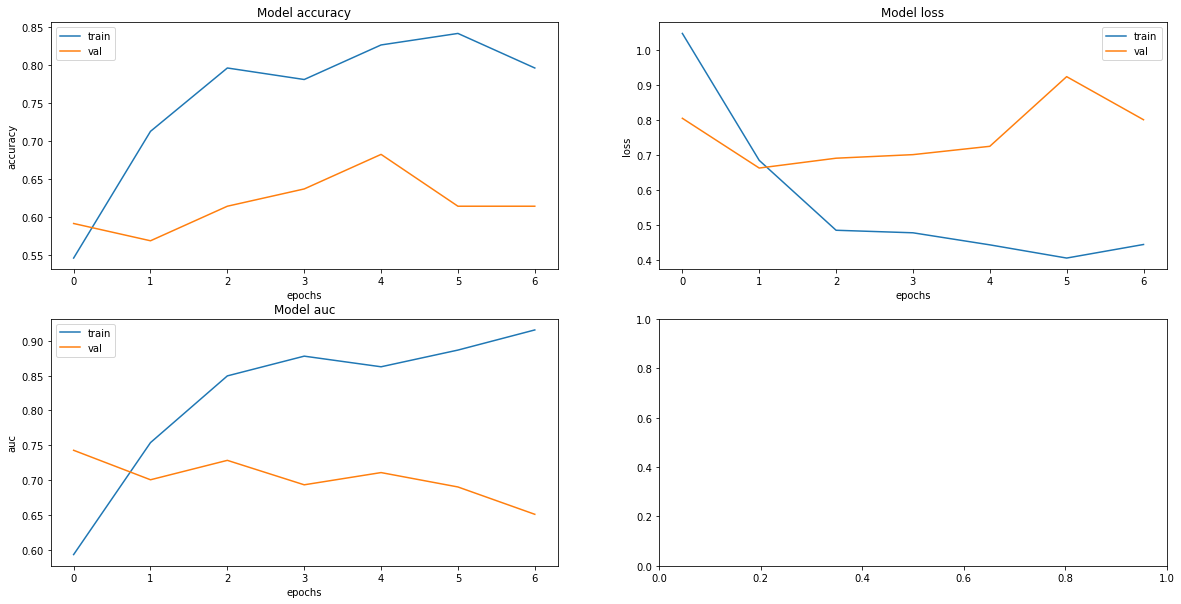

In [86]:
def plot_metrics(model_history,list_of_metrics):
    
    rows = int(np.ceil(len(list_of_metrics)/2))
    columns = 2
    
    fig, ax = plt.subplots(rows, columns, figsize=(20, 10))
    ax = ax.ravel()

    for i, metric in enumerate(list_of_metrics):
        ax[i].plot(model_history.history[metric])
        ax[i].plot(model_history.history["val_" + metric])
        ax[i].set_title("Model {}".format(metric))
        ax[i].set_xlabel("epochs")
        ax[i].set_ylabel(metric)
        ax[i].legend(["train", "val"])
        
plot_metrics(H ,["accuracy", "loss", "auc"])

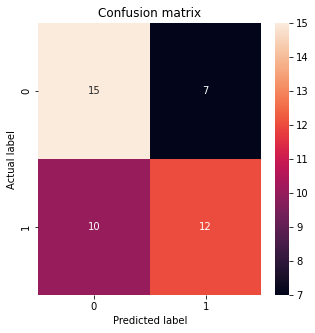

In [87]:
test_predictions_baseline = model.predict(X_test, batch_size=BATCH_SIZE)
plot_cm(y_test, test_predictions_baseline)

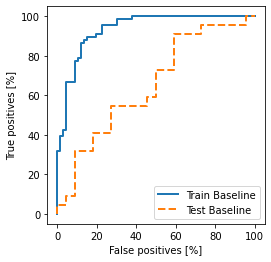

In [88]:
train_predictions_baseline = model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(X_test, batch_size=BATCH_SIZE)

plot_roc("Train Baseline", y_train, train_predictions_baseline)
plot_roc("Test Baseline", y_test, test_predictions_baseline, linestyle='--')
plt.legend(loc='lower right')

In [89]:
print_total_results(model, X_test, y_test)

loss :  0.7998943328857422
tp :  12.0
fp :  7.0
tn :  15.0
fn :  10.0
accuracy :  0.6136363744735718
precision :  0.6315789222717285
recall :  0.5454545617103577
auc :  0.6508264541625977
prc :  0.6270022988319397


**Although the best model suggested by the hyperparameter tuner stated a max of 86% val accuracy we can see the above results are not as good as our simple model and therefore we will use that one instead**

# Stratified KFold Cross Validation

**To check the robustness of our model we will use cross validation and assess the varriance and standard deviation in the results**

In [158]:
feature_selected_data.head()

,Staging(Tumor Size),Date of Birth (Days),Staging(Nodes),Tumor Grade Mitotic,Mol Subtype_luminal-like,Lymphadenopathy or Suspicious Nodes,Tumor Grade Tubule,PR,Tumor Grade Nuclear,Response to treatment
3,2.0,22685,1.0,1,1,1,3,1,2,1
5,2.0,13932,1.0,3,0,1,3,0,3,1
10,3.0,24712,2.0,2,0,1,3,0,3,1
12,2.0,15885,2.0,3,0,1,3,0,3,0
19,1.0,13100,1.0,1,1,0,3,1,2,0


In [159]:
y = feature_selected_data[['Response to treatment']]
X = feature_selected_data.drop(['Response to treatment'], axis = 1)

scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)

X = np.array(X)
y = np.array(y)

In [160]:
total_scores_dict = {'loss': [], 'tp':[], 'fp':[], 'tn':[], 'fn': [], 
                     'accuracy':[], 'precision': [], 'recall': [],
                     'auc':[], 'prc': []}
total_scores = []

skf = StratifiedKFold(n_splits=4)
skf.get_n_splits(X, y)


StratifiedKFold(n_splits=4, random_state=None, shuffle=False)

for train_index, test_index in skf.split(X, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    img_input = Input(shape=(input_shape, ))

    x = Dense(64, activation = "relu")(img_input)
    x = Dense(128, activation = "relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation = "relu")(x)
    x = Dropout(0.2)(x)

    predictions = Dense(1, activation = "sigmoid")(x)

    model = Model(inputs = img_input, outputs = predictions)
    
    model.compile(optimizer=tf.optimizers.Adam(learning_rate = 0.01),
              loss='binary_crossentropy',
              metrics= METRICS)
    
    history = model.fit(X_train,
                    y_train,
                    batch_size= BATCH_SIZE,
                    validation_data = (X_test, y_test), 
                    class_weight =class_weights,
                    callbacks=[checkpoint_cb, early_stop],
                    verbose = 0,
                    epochs=20)
    
    baseline_results = model.evaluate(X_test, y_test,
                                      batch_size=BATCH_SIZE, verbose=0)
    
    total_scores.append(baseline_results)
    
    for name, value in zip(model.metrics_names, baseline_results):
        total_scores_dict[name].append(value)
        #print(name, ': ', value)
        
    

In [161]:
#print(total_scores_dict)

In [162]:
metric_list = [statistics.mean, statistics.pstdev, statistics.stdev]
for metric in metric_list:
    print(metric ,"\n")
    for key in total_scores_dict:
        print(key, metric(total_scores_dict[key]))
    print("\n")

<function mean at 0x000002226E6C1700> 

loss 0.5564568638801575
tp 15.75
fp 6.0
tn 16.0
fn 6.25
accuracy 0.7215909212827682
precision 0.7250877320766449
recall 0.7159090936183929
auc 0.7830578684806824
prc 0.7599937170743942


<function pstdev at 0x000002226E6C1F70> 

loss 0.039577361906746024
tp 2.165063509461097
fp 1.4142135623730951
tn 1.4142135623730951
fn 2.165063509461097
accuracy 0.054201087723461806
precision 0.05110866790644203
recall 0.09841199052935129
auc 0.051580515962845484
prc 0.0664412738901765


<function stdev at 0x000002226E6C1EE0> 

loss 0.04570000110135011
tp 2.5
fp 1.632993161855452
tn 1.632993161855452
fn 2.5
accuracy 0.06258602517502239
precision 0.05901520634741498
recall 0.11363637844721573
auc 0.05956004955217726
prc 0.07671977473159011




#### Average F1 score and standard deviation of f1 score

In [164]:
precision=0.622
recall = 0.852
precision = statistics.mean(total_scores_dict["precision"])
recall = statistics.mean(total_scores_dict["recall"])

f1_score = 2* (precision*recall/(precision + recall))
print(f1_score)

0.7204691805124974


In [ ]:
precision = statistics.pstdev(total_scores_dict["precision"])
recall = statistics.pstdev(total_scores_dict["recall"])

f1_score = 2* (precision*recall/(precision + recall))
print(f1_score)